# Cross Validation
**Definition**
Cross-Validation is a statistical method of evaluating and comparing learning algorithms by dividing data into two segments: one used to learn or train a model and the other used to validate the model. In typical cross-validation, the training and validation sets must cross-over in successive rounds such that each data point has a chance of being validated against.

**Purpose**
* Get as much valid information as possible from limited learning data.
* Cross-validation can effectively avoid falling into local minima by  learning samples from multiple directions.
* The overfitting problem can be avoided to some extent.

**Types**
* Simple Cross Validation
* K-Ford Cross Validation
* Leave-one-out Cross Validation

**Usage**
Here is a flowchart of typical cross validation workflow in model training. The best parameters can be determined by grid search techniques

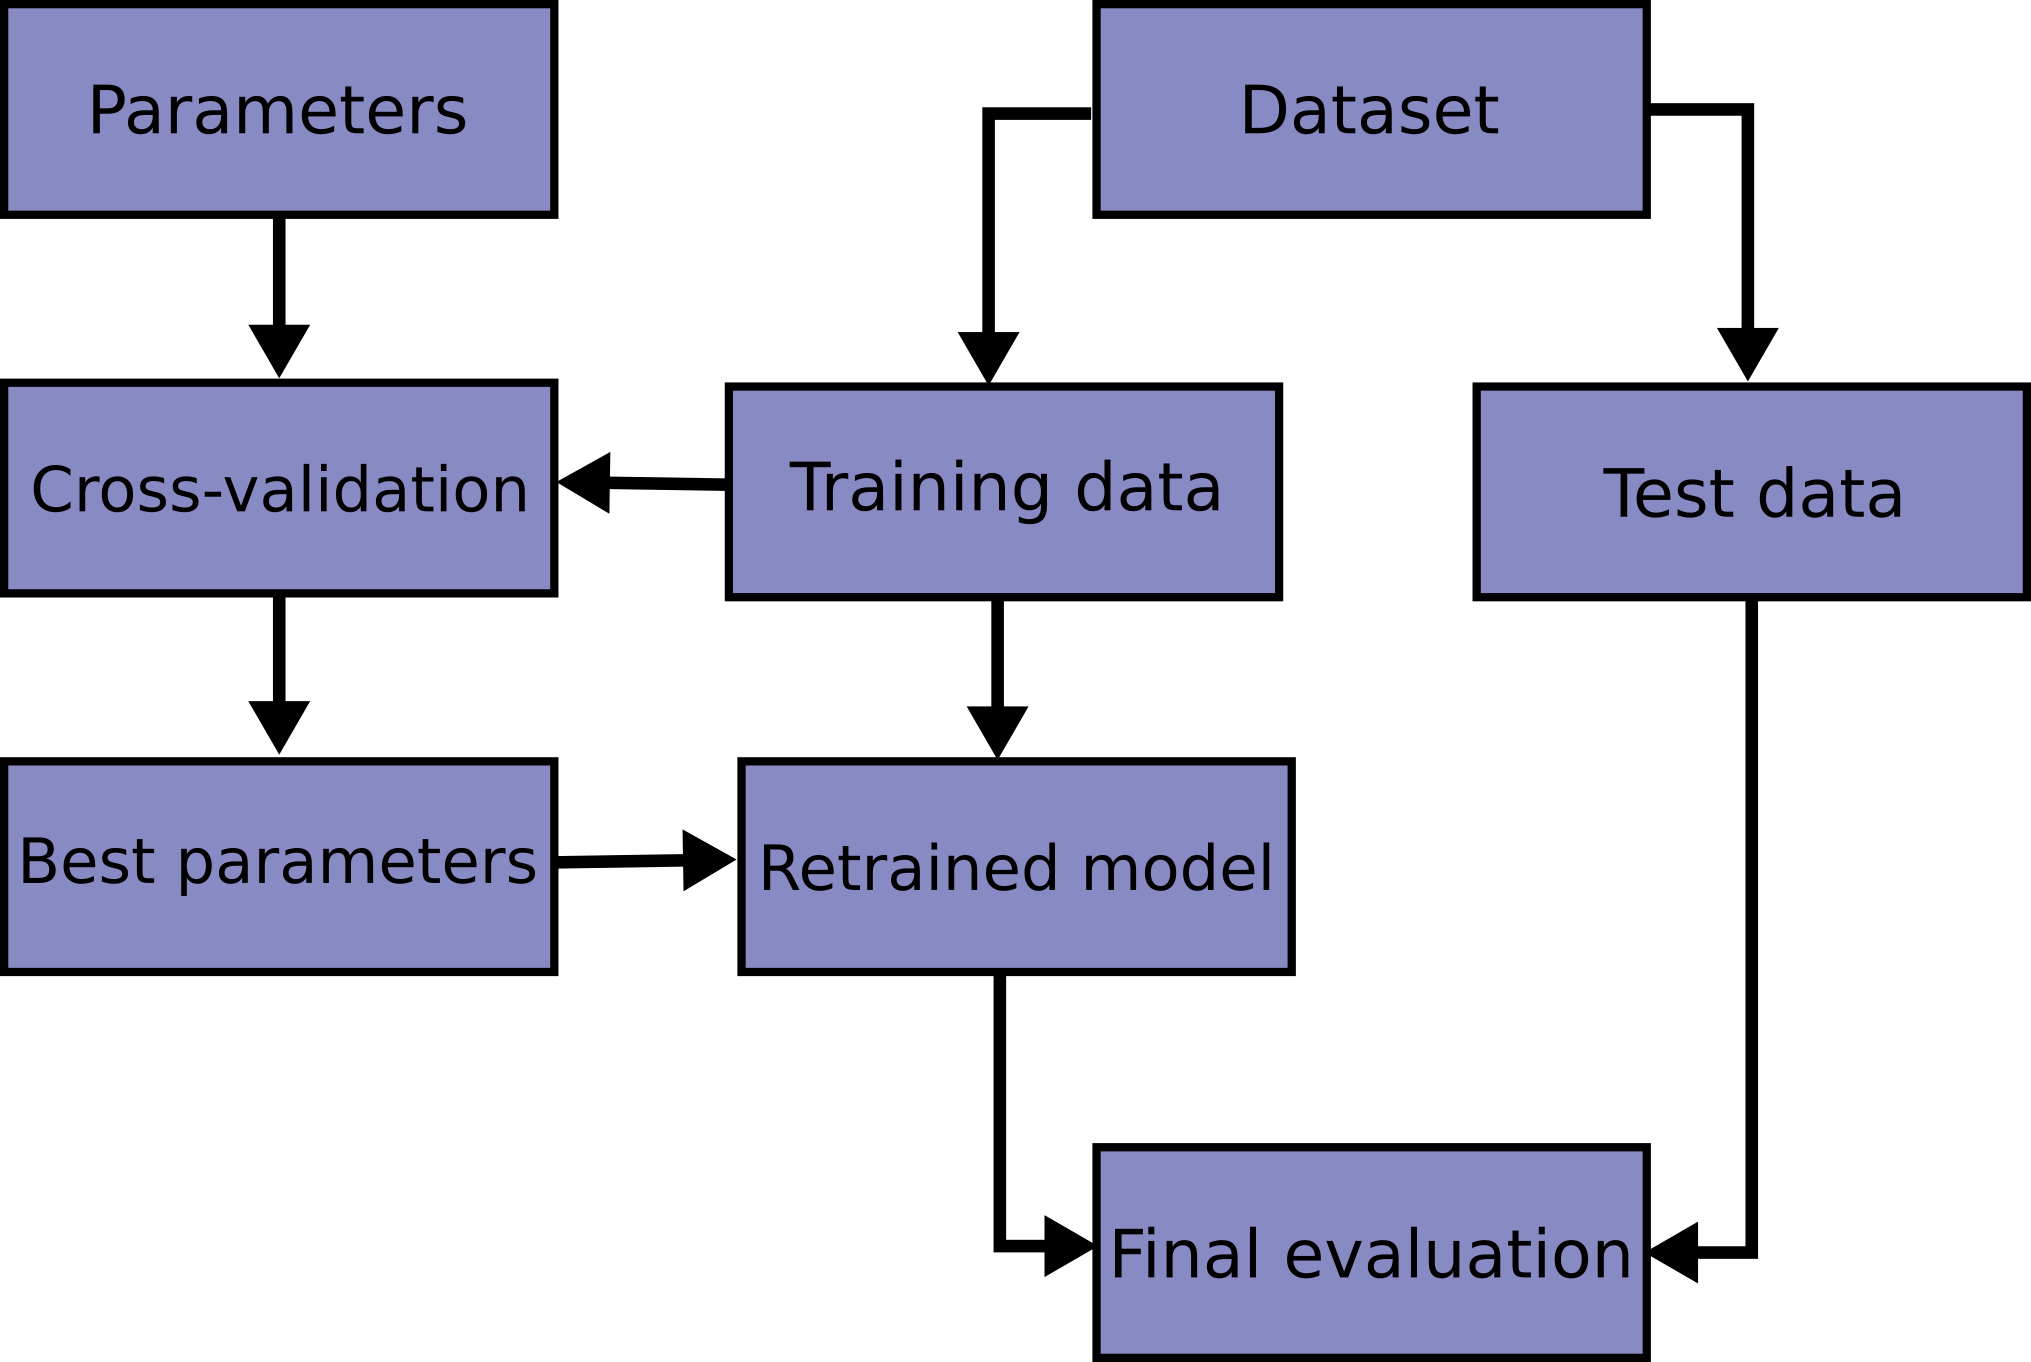

In [1]:
## use perceptron as example
## init labs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
# from sklearn.preprocessing import StandardScaler
import random

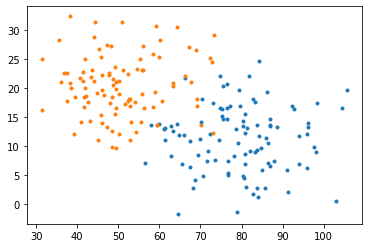

In [2]:
class1 = np.random.normal((80, 10), (10, 5), (100, 2))
class2 = np.random.normal((50, 20), (10, 5), (100, 2))
plt.plot(class1[:,0],class1[:,1],'.')
plt.plot(class2[:,0],class2[:,1],'.')

## Simple Cross Validation
Here we use perceptron as example. First, randomly divide the sample data into two parts (for example, 80% training set and 20% test set), then use the training set to train the model, and verify the model and parameters on the test set. Then the sample is shuffled, the training set and the test set are selected again, and the data is trained and the model is tested. Finally, the loss function is selected to evaluate the optimal model and parameters. In the following method, we only shuffle the data once.

In [3]:

class Perceptron(object):

    def __init__(self, n_inputs, max_epochs=100, learning_rate=0.01):
        """
        Initializes the perceptron object.
        - n_inputs: Number of inputs.
        - max_epochs: Maximum number of training cycles.
        - learning_rate: Magnitude of weight changes at each training cycle.
        - weights: Initialize weights (including bias as the first weight).
        """
        self.n_inputs = n_inputs  # Initialize number of inputs
        self.max_epochs = max_epochs  # Initialize maximum number of epochs
        self.learning_rate = learning_rate  # Initialize learning rate
        # Initialize weights with zeros (+1 for the bias)
        self.weights = np.zeros(n_inputs + 1)
        
    def forward(self, input_vec):
        """
        Predicts label from input.
        Args:
            input_vec (np.ndarray): Input array of training data, input vec can be one sample or all samples,
            depended on your implementation. 
        Returns:
            int: Predicted label (1 or -1).
        """
        # Add bias term at the beginning of input_vec
        activation = np.dot(input_vec, self.weights[1:]) + self.weights[0]
        return 1 if activation >= 0 else -1
        
    def train(self, training_inputs, labels):
        """
        Trains the perceptron.
        Args:
            training_inputs (list of np.ndarray): List of numpy arrays of training points.
            labels (np.ndarray): Array of expected output values for the corresponding point in training_inputs.
        """
        for _ in range(self.max_epochs):
            for xi, target in zip(training_inputs, labels):
                # Prediction with the current weights
                prediction = self.forward(xi)
                # Calculate the error
                error = target - prediction
                # Update the weights: w = w + learning_rate * (target - prediction) * xi
                # Update the bias: the same rule but xi is considered as 1
                self.weights[1:] += self.learning_rate*np.float32(error)*np.array(xi)#update weight
                self.weights[0] += self.learning_rate*np.array(error)# update bias

In [4]:
# you can repeat this section to find the better model and parameters
train_1 = [[[n[0], n[1]],1] for n in class1[:80]]
train_2 = [[[n[0], n[1]],-1] for n in class2[:80]]
train_1.extend(train_2)
train = train_1
random.shuffle(train)
train = np.array(train)

test_1 = [[[n[0], n[1]],1] for n in class1[20:]]
test_2 = [[[n[0], n[1]],-1] for n in class2[20:]]
test_1.extend(test_2)
test = np.array(test_1)

<ipython-input-4-b6044cdabac3>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train = np.array(train)
<ipython-input-4-b6044cdabac3>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test = np.array(test_1)


In [5]:

print("-------train:Simple------")
best_weight = np.zeros(2 + 1)
best_acc = 0
for i in range(0,5):
    random.shuffle(train)
    train = np.array(train)
    train_cv = train[:128]
    test_cv = train[128:]
    linear = Perceptron(2)
    linear.train(train_cv[:,0], train_cv[:,1])

    accs = 0
    for i in range(len(test_cv)):
        pred = linear.forward(test_cv[i,0])
        if pred == test_cv[i,1]: accs += 1
    racc=accs/len(test_cv)
    print(racc)

    if(best_acc<racc):
        best_acc=racc
        best_weight=linear.weights

print("-------test------")
accs = 0
for i in range(len(test)):
    activation = np.dot(test[i,0], best_weight[1:]) + best_weight[0]
    pred = np.where(activation>=0,1,-1)
    if pred == test[i,1]: accs += 1
print(accs/len(test))

-------train:Simple------
0.75
0.96875
1.0
1.0
1.0
-------test------
0.93125


## K-Fold Cross Validation
K-fold cross-validation will randomly divide the sample data into K pieces. Each time, K-1 pieces are randomly selected as the training set, and the remaining 1 pieces are used as the test set. When this round is complete, re-randomly select K-1 copies to train the data. After several rounds (less than K), the loss function is selected to evaluate the optimal model and parameters.
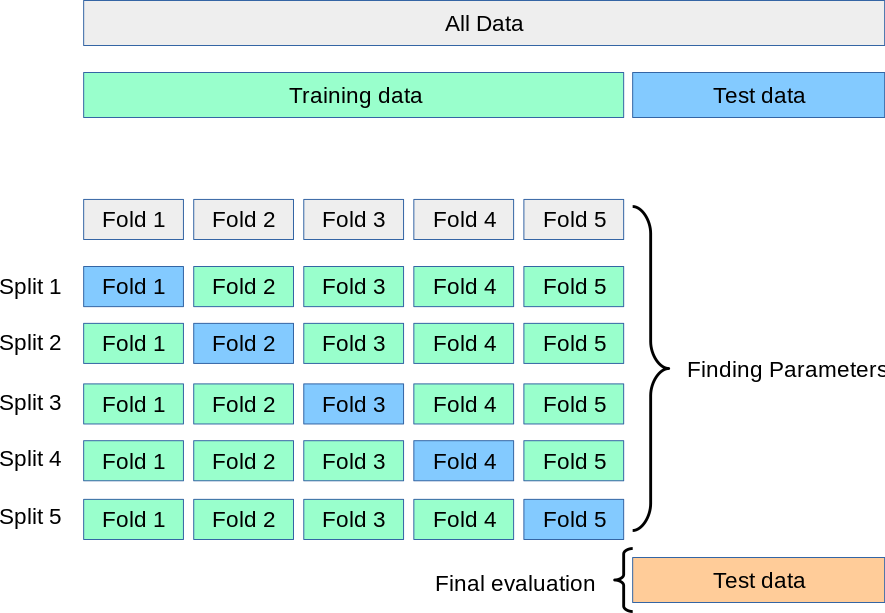

In [6]:
# train data
train_1 = [[[n[0], n[1]],1] for n in class1[:80]]
train_2 = [[[n[0], n[1]],-1] for n in class2[:80]]
train_1.extend(train_2)
train = train_1
random.shuffle(train)
train = np.array(train)

print("-------train:KFold------")
best_weight = np.zeros(2 + 1)
best_acc = 0
kf = KFold(n_splits=5, shuffle=False,random_state=None)
for i, (train_index, test_index) in enumerate(kf.split(train)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    train_cv = train[train_index]
    test_cv = train[test_index]
    linear = Perceptron(2)
    linear.train(train_cv[:,0], train_cv[:,1])

    accs = 0
    for i in range(len(test_cv)):
        pred = linear.forward(test_cv[i,0])
        if pred == test_cv[i,1]: accs += 1
    racc=accs/len(test_cv)
    print(racc)

    if(best_acc<racc):
        best_acc=racc
        best_weight=linear.weights
    

# test data
test_1 = [[[n[0], n[1]],1] for n in class1[20:]]
test_2 = [[[n[0], n[1]],-1] for n in class2[20:]]
test_1.extend(test_2)
test = np.array(test_1)

print("-------test------")
accs = 0
for i in range(len(test)):
    activation = np.dot(test[i,0], best_weight[1:]) + best_weight[0]
    pred = np.where(activation>=0,1,-1)
    if pred == test[i,1]: accs += 1
print(accs/len(test))



<ipython-input-6-f5b067a8721f>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train = np.array(train)


-------train:KFold------
Fold 0:
  Train: index=[ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159]
  Test:  index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
0.9375
Fold 1:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102

<ipython-input-6-f5b067a8721f>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test = np.array(test_1)


## Leave-one-out Cross Validation
It is a special case of the second case, where K is equal to the number of samples N, so that for N samples, n-1 samples are selected at a time to train the data, leaving one sample to verify the model's prediction. This method is mainly used when the sample size is very small, for example, when the sample size is less than 50, the Leave-one-out cross-validation is generally adopted.
Here we will not post detail code.

## Reference
[1] https://scikit-learn.org/stable/modules/cross_validation.html

[2] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold

[3] Refaeilzadeh, P., Tang, L., Liu, H. (2009). Cross-Validation. In: LIU, L., ÖZSU, M.T. (eds) Encyclopedia of Database Systems. Springer, Boston, MA.

[4] https://mp.weixin.qq.com/s/BF1378_Kr6ILmZFIXOi77A

[5] Sustech, Course CS324 Deep Learning, Assignment1